# Introduction

This lab focuses on the use of Bernoulli Restricted Boltzmann Machine (RBM) for classification of handwritten digits. The RBM feature extractor is combined with a logistic regression classifier to predict the digits. The dataset used is a greyscale image data where pixel values can be interpreted as degrees of blackness on a white background.

# Data Preparation

In this step, we prepare the data for training and testing. We use **load_digits** function from **sklearn.datasets** to get the dataset. We then artificially generate more labeled data by perturbing the training data with linear shifts of 1 pixel in each direction. We scale the data between 0 and 1.

In [4]:
import numpy as np
from scipy.ndimage import convolve
from sklearn import datasets
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [1, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 1], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 1, 0]],
    ]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode="constant", weights=w).ravel()

    X = np.concatenate(
        [X] + [np.apply_along_axis(shift, 1, X, vector) for vector in direction_vectors]
    )
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

X, y = datasets.load_digits(return_X_y=True)
X = np.asarray(X, "float32")
X, Y = nudge_dataset(X, y)
X = minmax_scale(X, feature_range=(0, 1))  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

Function nudge_dataset(X, Y)
This function creates an augmented dataset by shifting each image by 1 pixel in four directions: left, right, up, and down.

direction_vectors — These are 4 convolution kernels used to simulate shifts in different directions.

shift(x, w) — Applies the convolution kernel w to the image x (which is reshaped to 8×8).

Inside np.concatenate:

The original images X are combined with 4 sets of shifted versions.

As a result, the new X becomes 5 times larger in terms of number of samples.

The labels Y are duplicated to match the new number of images.

The digits dataset is loaded from sklearn, which contains 1797 samples of handwritten digits (each 8×8 pixels).

The data is converted to float32.

The nudge_dataset function increases the dataset size by a factor of 5 (about 9000 samples).

minmax_scale scales all pixel values to the range [0, 1].

# Model Definition


In this step, we define the classification pipeline with a BernoulliRBM feature extractor and a logistic regression classifier. We use **BernoulliRBM** and **LogisticRegression** classes from **sklearn.neural_network** and **sklearn.linear_model** modules respectively. We then create a pipeline object **rbm_features_classifier** to combine the two models.

In [8]:
from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)
rbm = BernoulliRBM(verbose=True, random_state=0)

rbm_features_classifier = Pipeline(steps=[("rbm", rbm), ("logistic", logistic)])

# Training

In this step, we train the pipeline model defined in the previous step. We set the hyperparameters of the model (learning rate, hidden layer size, regularization), and then fit the training data to the model.

In [10]:
from sklearn.base import clone

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learing_rate = 0.06
rbm.n_iter = 10

# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)



[BernoulliRBM] Iteration 1, pseudo-likelihood = -24.84, time = 0.89s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -22.85, time = 0.66s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -21.82, time = 0.47s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -20.91, time = 0.47s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -20.52, time = 0.46s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -20.25, time = 0.43s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.01, time = 0.40s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -19.78, time = 0.41s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -19.84, time = 0.41s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -19.62, time = 0.40s


,steps,"[('rbm', ...), ('logistic', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,100
,learning_rate,0.1
,batch_size,10
,n_iter,10
,verbose,True
,random_state,0
,penalty,'l2'


# Evaluation

In this step, we evaluate the performance of the model on the test dataset. We use **classification_report** function from **sklearn.metrics** module to generate the classification report for both the pipeline model and the logistic regression model.

In [14]:
from sklearn import metrics

Y_pred = rbm_features_classifier.predict(X_test)
print(
    "Logistic regression using RBM features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.0
raw_pixel_classifier.fit(X_train, Y_train)

Y_pred = raw_pixel_classifier.predict(X_test)
print(
    "Logistic regression using raw pixel features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.10      1.00      0.18       174
           1       0.00      0.00      0.00       184
           2       0.00      0.00      0.00       166
           3       0.00      0.00      0.00       194
           4       0.00      0.00      0.00       186
           5       0.00      0.00      0.00       181
           6       0.00      0.00      0.00       207
           7       0.00      0.00      0.00       154
           8       0.00      0.00      0.00       182
           9       0.00      0.00      0.00       169

    accuracy                           0.10      1797
   macro avg       0.01      0.10      0.02      1797
weighted avg       0.01      0.10      0.02      1797


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.10      1.00      0.18       174
           1       0.00      0.00      0.00  

C:\Users\rudet\AppData\Roaming\JetBrains\DataSpell2025.1\projects\workspace\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\rudet\AppData\Roaming\JetBrains\DataSpell2025.1\projects\workspace\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\rudet\AppData\Roaming\JetBrains\DataSpell2025.1\projects\workspace\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted

# Plotting

In this step, we plot the 100 components extracted by the RBM. We use **matplotlib.pyplot** module to plot the images.

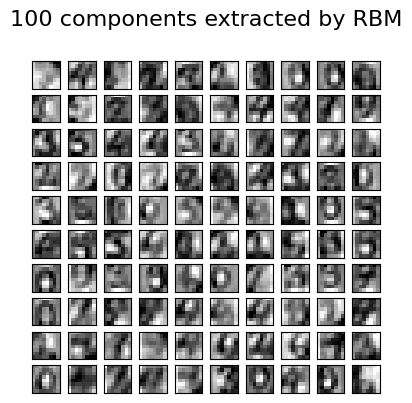

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("100 components extracted by RBM", fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

# Summary

In this lab, we learned how to use Bernoulli Restricted Boltzmann Machine (RBM) with logistic regression for classification of handwritten digits. We also learned how to evaluate the performance of the model using classification report and how to plot the components extracted by RBM.